In [25]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F

from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor

import torchvision   
from torchvision.utils import save_image 

from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  
import traceback

import matplotlib.pyplot as plt   
import numpy as np 
from captum.attr import Deconvolution 

In [26]:
def process_image_with_deconvolution(  
    img_path,   
    model_weights=ResNet50_Weights.DEFAULT  
):  
    """  
    专注于图像处理和归因计算的函数  
    
    参数:  
    - img_path: 图像路径  
    - model_weights: 模型权重  
    
    返回:  
    包含归因结果和预测信息的字典  
    """  
    # 加载 ImageNet 类别名称  
    imagenet_classes = ResNet50_Weights.DEFAULT.meta["categories"]  
    
    # 预处理转换  
    test_transform = transforms.Compose([  
        transforms.Resize(256),  
        transforms.CenterCrop(224),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 设备选择  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # 加载并预处理图像  
    img_pil = Image.open(img_path).convert('RGB')  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  
    input_tensor.requires_grad_(True)  

    # 初始化 Deconvolution  
    deconv = Deconvolution(model)  

    # 获取模型预测的类别  
    with torch.no_grad():  
        output = model(input_tensor)  
        predicted_class = torch.argmax(output).item()  

    # 计算 Deconvolution 归因  
    attributions = deconv.attribute(  
        input_tensor,   
        target=predicted_class  
    )  

    return {  
        'attributions': attributions,  
        'input_tensor': input_tensor.squeeze(),  
        'predicted_class': predicted_class,  
        'class_name': imagenet_classes[predicted_class],  
        'class_names': imagenet_classes  
    }  

In [42]:
import matplotlib.pyplot as plt  
import numpy as np  
import torch  

def visualize_attribution_map(  
    attributions,  
    original_image=None,  
    predicted_class=None,  
    class_names=None,  
    title_prefix='Attribution'  
):  
    """  
    可视化归因映射的函数  

    参数:  
    - attributions: 归因结果  
    - original_image: 原始图像  
    - predicted_class: 预测类别  
    - class_names: 类别名称映射  
    - title_prefix: 标题前缀  
    """  
    # 处理归因结果  
    if torch.is_tensor(attributions):  
        attributions = attributions.detach().cpu().numpy()  

    # 确定类别名称  
    if predicted_class is not None and class_names:  
        class_name = class_names[predicted_class]  
    elif predicted_class is not None:  
        class_name = f'Class {predicted_class}'  
    else:  
        class_name = None  

    # 平均归因图  
    if attributions.ndim > 2:  
        mean_attribution = np.abs(attributions).mean(axis=0)  
    else:  
        mean_attribution = np.abs(attributions)  

    # 将 mean_attribution 转换为二维图像（H x W）  
    if mean_attribution.ndim == 3:  # 处理 (C, H, W)  
        mean_attribution = mean_attribution.mean(axis=0)  # 取均值，得到 (H, W)  

    # 如果没有原始图像，创建单独的热力图  
    if original_image is None:  
        fig, ax = plt.subplots(figsize=(10, 8))  
        im = ax.imshow(mean_attribution, cmap='hot', aspect='auto')  # 使用热图色图  
        ax.set_title(f'{title_prefix} Mean Attribution Map')  
        ax.axis('off')  
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  

    # 如果提供了原始图像，创建对比图  
    else:  
        # 确保原始图像是 numpy 数组  
        if torch.is_tensor(original_image):  
            original_image = original_image.detach().permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)  
            # 如果图像是标准化的，需要反归一化  
            original_image = original_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  
            original_image = np.clip(original_image, 0, 1)  

        # 创建对比图  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  

        # 原始图像  
        ax1.imshow(original_image)  
        ax1.set_title('Original Image')  
        ax1.axis('off')  

        # 热力图叠加  
        ax2.imshow(original_image, alpha=0.5)  
        im = ax2.imshow(mean_attribution, cmap='jet', alpha=0.5)  

        # 添加标题和类别信息  
        title = f'{title_prefix} Attribution Heatmap'  
        if class_name:  
            title += f'\n{class_name}'  
        ax2.set_title(title)  
        ax2.axis('off')  

        plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)  

    plt.tight_layout()  
    return fig

In [43]:
def test(img_path):  
    # 处理图像并获取归因结果  
    result = process_image_with_deconvolution(img_path)  
    
    # 可视化方法1：仅热力图  
    fig1 = visualize_attribution_map(  
        result['attributions'],   
        title_prefix='Deconvolution'  
    )  
    
    # 可视化方法2：包含原始图像  
    fig2 = visualize_attribution_map(  
        result['attributions'],   
        original_image=result['input_tensor'],   
        predicted_class=result['predicted_class'],  
        class_names=result['class_names'],  
        title_prefix='Deconvolution'  
    )  
    
    plt.show()  
    print(f"Predicted: {result['class_name']}") 

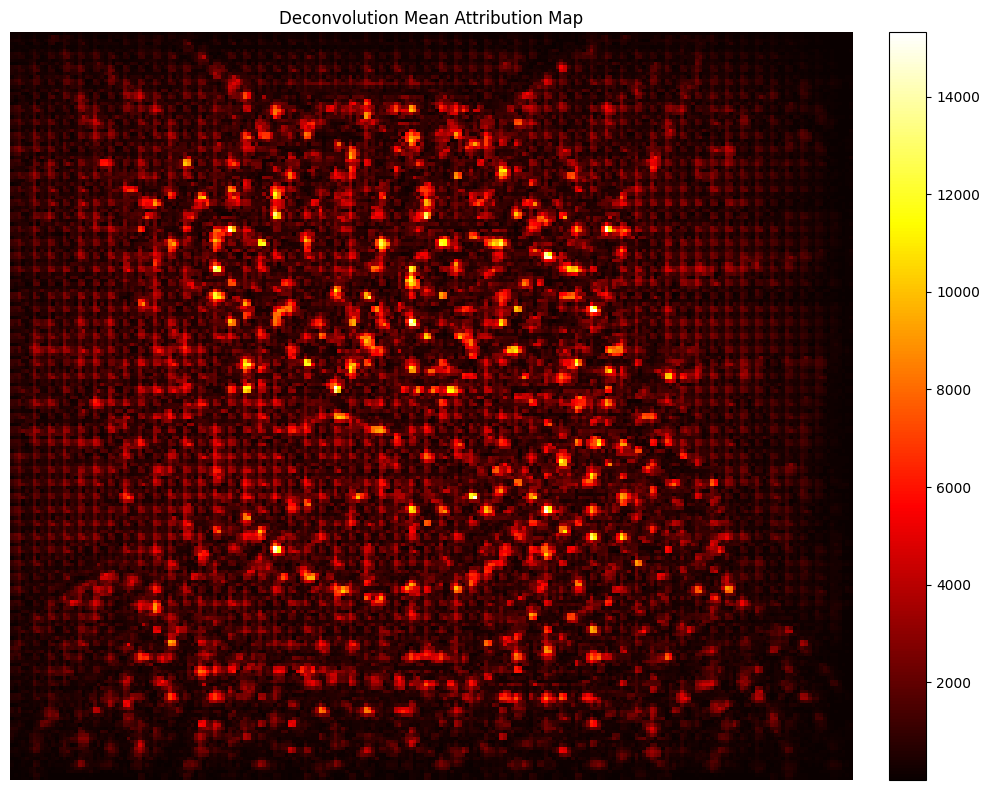

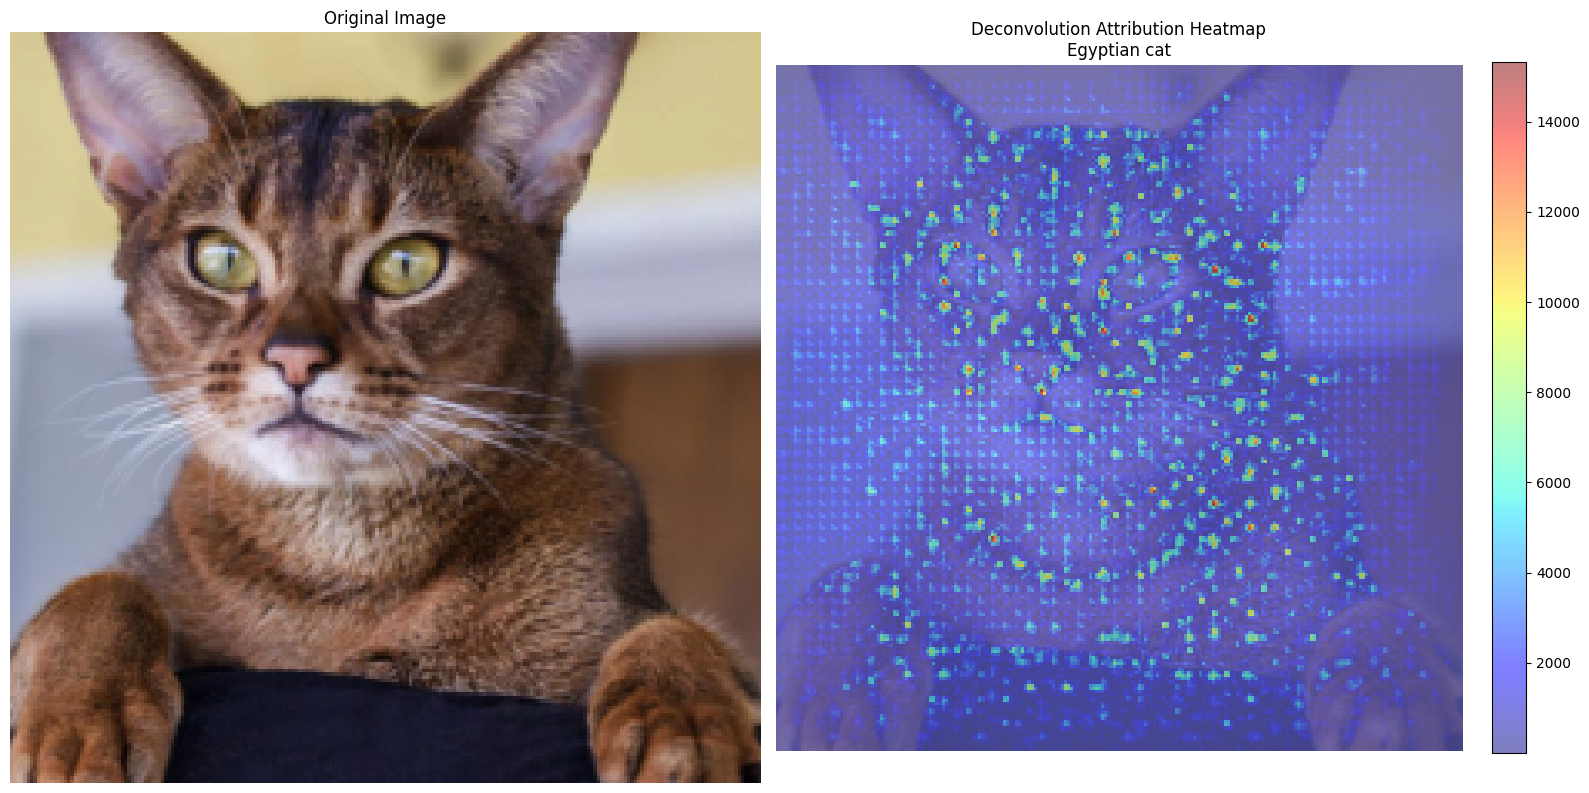

Predicted: Egyptian cat


In [48]:
img_path = "dataset/埃及猫/5.jpg"
test(img_path)